# CODICE STRUTTURA

## Parte 1

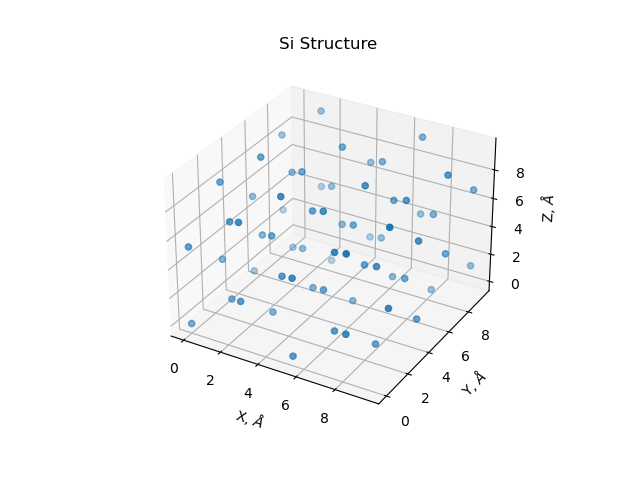

In [1]:
%matplotlib widget
import numpy as np
from pymatgen.core import Structure
from pymatgen.analysis.chemenv.utils import coordination_geometry_utils as cgu
import matplotlib.pyplot as plt

import scipy 

Material = "Si"
# Load the crystal structure of silicon
path_cif = Material+".cif"
structure = Structure.from_file(path_cif)

a_lattice, b_lattice, c_lattice = [structure.lattice.abc[i] for i in range(0,len(structure.lattice.abc))]
alfa_lattice, beta_lattice, gamma_lattice = structure.lattice.angles

# Replicate the unit cell to obtain a larger cell
supercell = structure.make_supercell([2, 2, 2])

# Extract the positions of the atoms
positions = structure.cart_coords

# Round the coordinates of each position to two decimal places
for position in positions:
    for coordinate in position:
        coordinate = round(coordinate,2)
    #print(position)
#print(positions)

# Plot the positions of the atoms in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_title(Material+" Structure")
ax.set_xlabel('X, $\AA$')
ax.set_ylabel('Y, $\AA$')
ax.set_zlabel('Z, $\AA$')
plt.show()

asse  [1 1 0]


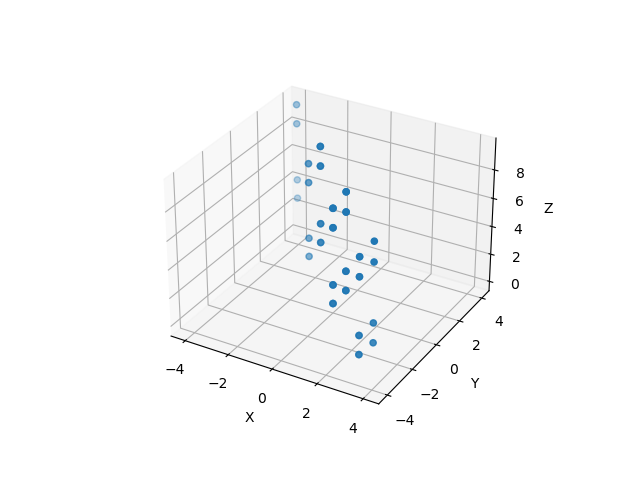

In [2]:
#selection of the axis for plane/axis projection
asse = r"1 1 0"
print ("asse ", np.fromstring(asse, dtype=int, sep=" "))

## Creates the axis vector to project all the points on the plane (normalizing it)##
norm_vector = np.fromstring(asse, dtype=int, sep=" ")
norma = np.linalg.norm(norm_vector)
norm_vector = norm_vector/norma

vector_projections = []
for position in positions:
    pr_scalar = np.dot(position, norm_vector) * norm_vector
    #print(" position", position)
    #print(" pr_scalar", pr_scalar)
    #projection = pr_scalar/norma
    vector_projection = np.array(position) - (pr_scalar) # projection *
    vector_projections.append(vector_projection)

#print(vector_projections)

soglia = 1e-10

# Iterate over the vector projections and convert them all to np.arrays
for prj in vector_projections:
    # Set values smaller than the threshold to zero
    prj[np.abs(prj)< soglia] = 0.0
    #print(prj)

# Convert the vector projections to a numpy array
ndarray_projs = np.array(vector_projections)

# Plot the vector projections in 3D space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ndarray_projs[:,0], ndarray_projs[:,1], ndarray_projs[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


[ 0.70710678 -0.70710678  0.        ]
90.0


Text(0.5, 0, 'Z')

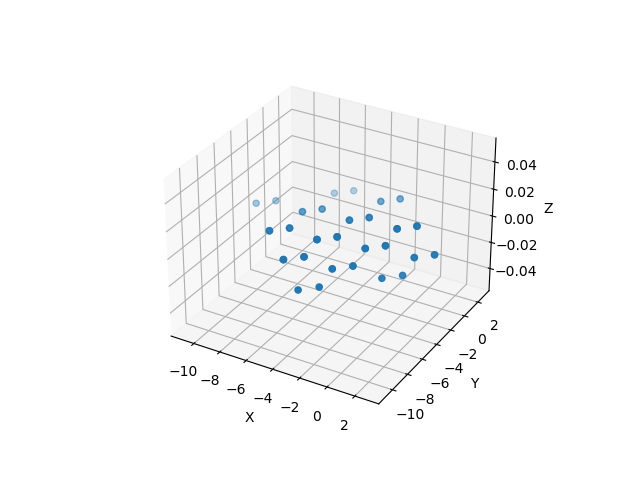

In [3]:
# Define three base vectors for x, y and z
x_base = np.array([1, 0, 0])
y_base = np.array([0, 1, 0])
z_base = np.array([0, 0, 1])

# Calculate the rotation axis for a given normal vector
rotation_axis = np.cross(norm_vector, z_base)
print(rotation_axis)

# Calculate the rotation angle for a given normal vector
angle = np.arccos(np.dot(norm_vector,z_base)/(np.sqrt(norm_vector[0]**2 + norm_vector[1]**2 + norm_vector[2]**2)*np.sqrt(z_base[0]**2 + z_base[1]**2 + z_base[2]**2)))
print(np.degrees(angle))

# Define the rotation matrix for a given rotation axis and angle
c = np.cos(angle)
def rotation_matrix(axis, theta):
    """
    Returns the rotation matrix for a rotation around a specified axis by a specified angle in radians 
    using Rodrigues' formula.
    """
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(theta/2.)
    b, c, d = -axis * np.sin(theta/2)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# Calculate the rotated projection vectors
R = rotation_matrix(rotation_axis, angle)
r_ndarray_projs = []
for p in ndarray_projs:
    r_ndarray_proj = np.dot(R, p)
    #print("rotated",r_ndarray_proj)
    r_ndarray_projs.append(r_ndarray_proj)

# Apply a threshold to each of the rotated projection vectors
for prj in r_ndarray_projs:
    prj[np.abs(prj) < soglia] = 0.0

# Plot the rotated projection vectors in 3D space
r_ndarray_projs = np.array(r_ndarray_projs)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_ndarray_projs[:,0], r_ndarray_projs[:,1], r_ndarray_projs[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


In [4]:
x_positions = []
y_positions = []
atom_positions = []
for a in range(0,len(r_ndarray_projs)):
    atom_positions.append((round(r_ndarray_projs[a][0],3),round(r_ndarray_projs[a][1],3)))
    x_positions.append(round(r_ndarray_projs[a][0],3))
    y_positions.append(round(r_ndarray_projs[a][1],3))
#print(atom_positions)
atom_positions = list(set(atom_positions))
#print("at_pos", atom_positions)
print("Number of projected atoms:",len(atom_positions))

posizioni_proiettate = []

for position in positions:
    p_scalare = np.dot(position, norm_vector)

    # calculates the length of the projection vector
    norma_asse = np.linalg.norm(norm_vector)

    # calcola la proiezione della posizione lungo l'asse
    d_proiezione = round(p_scalare / norma_asse, 3)

    posizioni_proiettate.append(d_proiezione)

posizioni_proiettate = list(set(posizioni_proiettate))
#print(posizioni_proiettate)

planar_distances = [round(posizioni_proiettate[n+1]-posizioni_proiettate[n],2) for n in range(0, len(posizioni_proiettate)-1)]
d_pl = []
if planar_distances.count(planar_distances[0]) == len(planar_distances):
    d_pl.append(planar_distances[0])
else:
    d_pl = list(set(planar_distances))
print("d_pl = ",d_pl)

################################## d_at CALCULATION ##################################

def punto_retta_scalare(v1,r):
    r_norm = np.linalg.norm(r)
    v1_norm = np.linalg.norm(v1)
    # print (round(v1_norm,2))
    # print (round(r_norm,2))
    pr_scalar=np.dot(v1, r)
    # print (pr_scalar, " -- ", v1_norm*r_norm)
    if abs(pr_scalar - v1_norm*r_norm)<0.01:
        return True
    else:
        return False
    
pos_ax =[]
for position in positions:
    test2 = punto_retta_scalare(position,norm_vector*norma)
    if test2 == True:
        #print (position)
        pos_ax.append(position) 


for at in pos_ax: #to make all np.arrays
    # print (atoms)
    at[np.abs(at)< soglia] = 0.0
    

pos_ax=np.sort(np.array(pos_ax), axis=0)
axial_projections = [np.sqrt((at[0])**2+(at[1])**2+(at[2])**2) for at in pos_ax] # è un nome a caso

axial_distances = [round(axial_projections[n+1]-axial_projections[n],2) for n in range(0, len(axial_projections)-1)]
d_at = []
if axial_distances.count(axial_distances[0]) == len(axial_distances):
    d_at.append(axial_distances[0])
else:
    d_at = list(set(axial_distances))
print("d_at = ",d_at)

'''fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_ax[:,0], pos_ax[:,1], pos_ax[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()'''

Number of projected atoms: 28
d_pl =  [1.92]
d_at =  [3.84]


"fig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\nax.scatter(pos_ax[:,0], pos_ax[:,1], pos_ax[:,2])\nax.set_xlabel('X')\nax.set_ylabel('Y')\nax.set_zlabel('Z')\nplt.show()"

In [5]:
#################################################################### Silicon
if "Si" in path_cif:
    coeff_a = [1.876, 2.617, 0.8604, 0.3903, 0.07769]
    coeff_b = [62.11, 18.68, 3.935, 0.7690, 0.0823]
    coeff_B = [b/(4*(np.pi)**(2)) for b in coeff_b]
    u = 0.075 #preso da sytov thesis
    N = 4.995E-2 #atomic concentration
    Z = 14
################################################################### Germanium
elif "Ge" in path_cif:
    coeff_a = [0.2259E+01, 0.2746E+01, 0.1533E+01, 0.6738E+00, 0.1563E+00]
    coeff_b = [0.5883E+02, 0.1588E+02, 0.2957E+01, 0.6679E+00, 0.7455E-01]
    coeff_B = [b/(4*(np.pi)**(2)) for b in coeff_b]
    u = 0.085 #from Baier Katkov
    N = 4.42E-2 #atomic concentration
    Z = 32
################################################################### Germanium
elif "W" in path_cif:
    coeff_a = [0.3467E-01, 0.1775E+00, 0.2189E+00, 0.1268E+00, -0.4894E-01]
    coeff_b = [0.1895, 0.3829E+01, 0.8004E+00, 0.1958E+00, 0.1958E+00]
    coeff_B = [b/(4*(np.pi)**(2)) for b in coeff_b]
    u = 0.050 #from Baier Katkov
    N = 0.168 #atomic concentration
    Z = 74
############################## COEFF MOLIERE
alfa = [0.1, 0.55, 0.35]
beta = [6.0, 1.2, 0.3]

z = 1
a_0 = scipy.constants.hbar/(scipy.constants.m_e*scipy.constants.c*scipy.constants.alpha)*10**10  #Angstrom
e = scipy.constants.e
a_TF = (9*np.pi**2/(128*Z))**(1/3)*a_0

def U_DT_2D(x, y, x_0, y_0):
    d_atm = sum(d_at)/len(d_at) #mean of the atomic distances
    U1 = 2/d_atm*Z*z*np.sqrt(1/137)*1973.2**2/0.511E6
    k1 = [(coeff_a[i]/(coeff_B[i]+2*u**2))*np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return U1*k

def U_DT_axial(x, y, x_0, y_0):
    d_atm = sum(d_at)/len(d_at) #mean of the atomic distances
    U1 = 2/d_atm*Z*z*(scipy.constants.hbar/scipy.constants.e)**2/0.511E6
    k1 = [(coeff_a[i]/(coeff_B[i]+2*u**2))*np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return U1*k

def U_DT_axial1(x, y, x_0, y_0):#Kyryllin
    d_atm = sum(d_at)/len(d_at) #mean of the atomic distances
    U1 = 8*np.pi**2*(1973.2)**2/(0.511E6*d_atm)
    k1 = [(coeff_a[i]/(coeff_b[i]+8*np.pi**2*u**2))*np.exp(-4*np.pi**2*((x-x_0)**2+(y-y_0)**2)/(coeff_b[i]+8*np.pi**2*u**2)) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return U1*k

def U_Lin_axial(x, y, x_0, y_0):
    d_atm = sum(d_at)/len(d_at) #mean of the atomic distances
    U1 = Z*z*e**2/(4*np.pi*scipy.constants.epsilon_0*12*d_atm)/e*10**10*np.log(1+3*a_TF**2/((x-x_0)**2+(y-y_0)**2))
    #k1 = [(coeff_a[i]/(coeff_b[i]+8*np.pi**2*u**2))*np.exp(-4*np.pi**2*((x-x_0)**2+(y-y_0)**2)/(coeff_b[i]+8*np.pi**2*u**2)) for i in range(0,len(coeff_a))]
    #k = sum(k1)
    return U1

################ Make the Potential calculation
x = np.linspace(min(x_positions), max(x_positions), 1000)
y = np.linspace(min(y_positions), max(y_positions), 1000)
xx, yy = np.meshgrid(x, y, indexing="ij")

x_0 = [0] * 100
y_0 = [0] * 100
xx_0, yy_0 = np.meshgrid(x_0,y_0)

U_2D= np.zeros_like(xx)
for atom in atom_positions:
    U_2D += U_DT_axial1(xx,yy,atom[0],atom[1])

U_max, U_min = [], []
for U in U_2D:
    U_max.append(max(U))
    U_min.append(min(U))
    
U_top, U_bottom = max(U_max), min(U_min)
print(U_top, U_bottom)

#U_2D -= U_bottom


132.6315696841265 7.35787895427243e-10


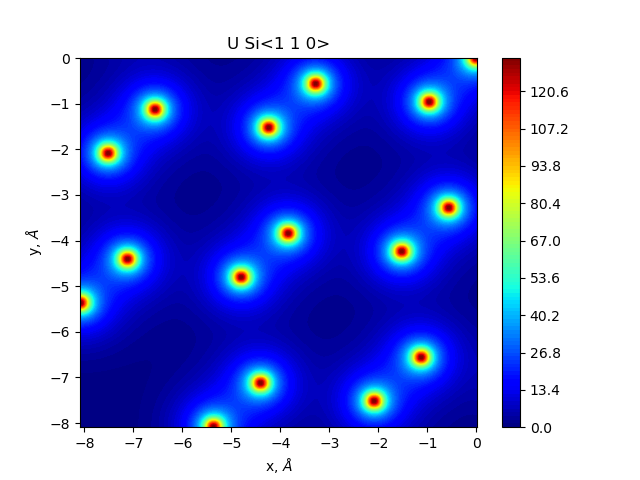

In [6]:
U_max, U_min = [], []
for U in U_2D:
    U_max.append(max(U))
    U_min.append(min(U))
    
U_top, U_bottom = max(U_max), min(U_min)

#x_plot = np.linspace(min(x_positions)/2, max(x_positions)/2, 1000)
#y_plot = np.linspace(min(y_positions)/2, max(y_positions)/2, 1000)
#xx_plot, yy_plot = np.meshgrid(x_plot, y_plot)
i_max, i_low = 800, 200
# Make the graph
levels = np.linspace(U_bottom, U_top, 100)
fig, ax=plt.subplots()
plt.contourf(xx[i_low:i_max,i_low:i_max], yy[i_low:i_max,i_low:i_max], U_2D[i_low:i_max,i_low:i_max], levels, cmap='jet') #levels,
plt.colorbar()
plt.title("U "+ Material + "<"+ asse +">") 
plt.xlabel('x, $\AA$')
plt.ylabel('y, $\AA$')
plt.show()

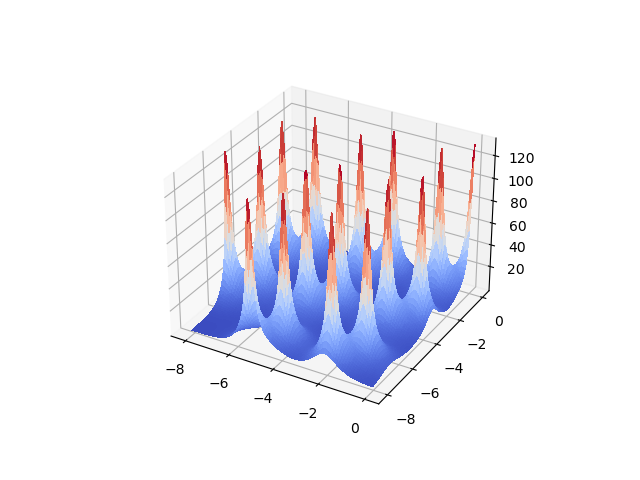

In [7]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


surf = ax.plot_surface(xx[i_low:i_max,i_low:i_max], yy[i_low:i_max,i_low:i_max], U_2D[i_low:i_max,i_low:i_max], cmap=cm.coolwarm, linewidth=0, antialiased=False, rcount=100, ccount=100) #cmap=cm.coolwarm,
#surf2 = ax.plot_surface(xx, yy, U_top*np.ones_like(xx) ,linewidth=0, antialiased=False)

5.430941
27.801778061713797


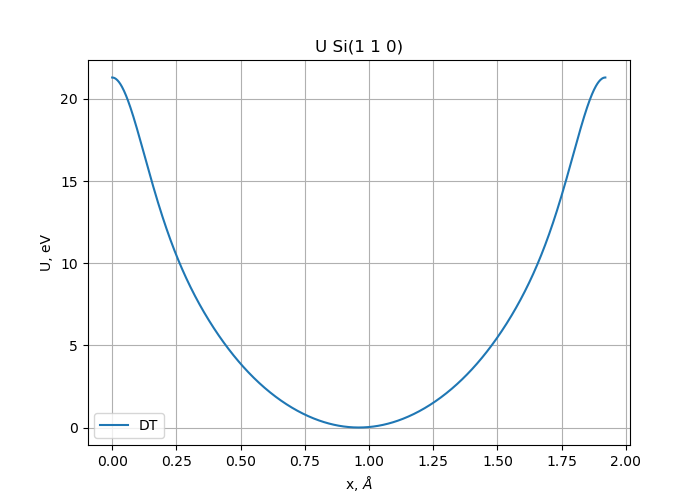

In [8]:
def U_pl_DT(x): 
    d_plm = sum(d_pl)/len(d_pl)
    U = 2*np.sqrt(np.pi)*N*d_plm*Z*z*1973.2**2/(0.511E6)*np.sqrt(1/137) #a_0*e**2=(hbar*c)^2/m_e
    k1 = [U*(coeff_a[i]/np.sqrt(coeff_B[i]+2*u**2))*np.exp(-x**2/(coeff_B[i]+2*u**2)) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return k

#coeff_a = [2.1293, 2.5333, 0.8349, 0.3216]
#coeff_b = [57.7748, 6.4756, 2.8796, 0.3860]
print(a_lattice)
def U_pl_DT2(x): 
    d_plm = sum(d_pl)/len(d_pl)
    d_atm = sum(d_at)/len(d_at)
    d_axis = a_lattice/2 #(1.92+2.70)/2 #<100>
    #d_axis = (1.36+2.52)/2 #<110>
    #d_axis = 2.22 #<111>
    U = 4*(np.pi)**(3/2)*(1973.2)**2/(0.511E6*d_axis*d_atm)
    k1 = [(coeff_a[i]/np.sqrt(coeff_b[i]+8*np.pi**2*u**2))*np.exp(-4*np.pi**2*x**2/(coeff_b[i]+8*np.pi**2*u**2)) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return U*k
print(U_pl_DT2(0))

x_DT = np.linspace(posizioni_proiettate[posizioni_proiettate.index(0.0)], posizioni_proiettate[posizioni_proiettate.index(0.0)+len(d_at)] , 1000)
posizioni_proiettate=[p-posizioni_proiettate[int(len(posizioni_proiettate)/2)] for p in posizioni_proiettate]
#print(posizioni_proiettate)
#U_harm = U_h_100(x_DT-d_pl/2)
'''#Moliere
U_Mol = [U_M(x_DT+n*d_pl) for n in range(-nel,nel)]
U_sum_Mol = sum(U_Mol)/e
U_sum_Mol = U_sum_Mol - min(U_sum_Mol)'''
#calculate for a number of planes
U_DT=[]
for n in range(0, len(posizioni_proiettate)):
    U_DT.append(U_pl_DT2(x_DT-posizioni_proiettate[n]))
U_sum_DT = sum(U_DT) #/e
#subtraction of the minimum energy
U_sum_DT = [U_sum_DT1 - min(U_sum_DT) for U_sum_DT1 in U_sum_DT]

figure, ax = plt.subplots(figsize=(7,5))

ax.plot(x_DT, U_sum_DT, label="DT")
ax.set_title("U "+ Material + "("+asse+")")
ax.set_ylabel("U, eV")
ax.set_xlabel("x, $\AA$")
ax.legend()
ax.grid()
plt.show()

In [9]:
print(max(U_sum_DT),min(U_sum_DT[0:150]))


21.299454794962198 9.156661239879412


## ELECTRIC FIELD AND ELECTRON DENSITY

457.3128294132019 5.483357065461224e-09


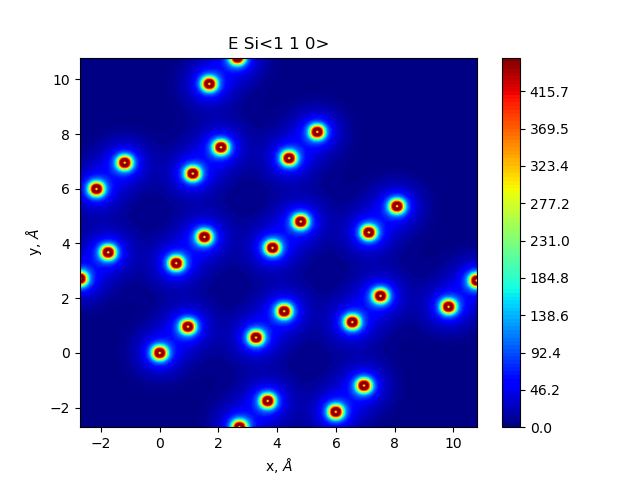

In [10]:
def gradient(x,y,x_0,y_0):
    d_atm = sum(d_at)/len(d_at)
    dU_dx = -2/d_atm*Z*z*e*a_0*sum([-2*(x-x_0)*coeff_a[i]/(coeff_B[i]+2*u**2)**2 * np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(len(coeff_a))])/e
    dU_dy = -2/d_atm*Z*z*e*a_0*sum([-2*(y-y_0)*coeff_a[i]/(coeff_B[i]+2*u**2)**2 * np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(len(coeff_a))])/e
    return dU_dx, dU_dy

E_tot= np.zeros_like(xx)
for atom in atom_positions:
    dU_dx, dU_dy = gradient(xx,yy,atom[0],atom[1]) 
    #print(dU_dx, dU_dy)
    E_tot += np.sqrt(dU_dx**2 + dU_dy**2)

E_max, E_min = [], []
for E in E_tot:
    E_max.append(max(E))
    E_min.append(min(E))
    
E_top, E_bottom = max(E_max), min(E_min)
print(E_top, E_bottom)
# Make the graph
levels = np.linspace(E_bottom, E_top, 100)
fig, ax=plt.subplots()
plt.contourf(-xx, -yy, E_tot, levels, cmap='jet') #levels,
plt.colorbar()
plt.title("E "+ Material + "<"+ asse +">") 
plt.xlabel('x, $\AA$')
plt.ylabel('y, $\AA$')
plt.show()

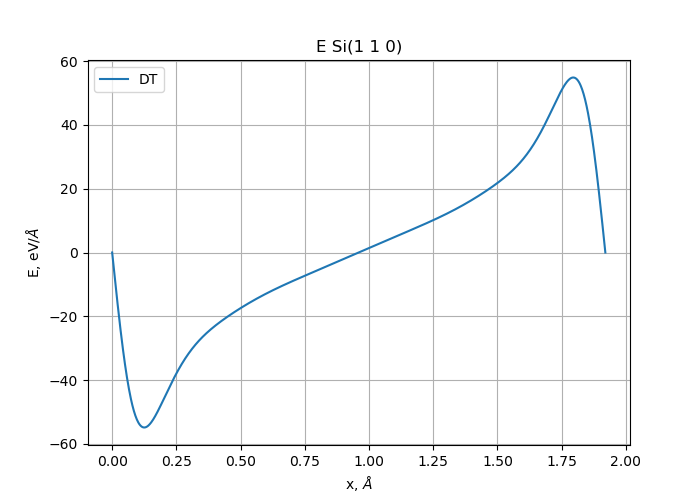

In [11]:
def E_pl_DT_dx(x):
    d_plm = sum(d_pl)/len(d_pl)
    E = 2*np.sqrt(np.pi)*N*d_plm*Z*z*e*a_0/e
    k1 = [-(2*x*coeff_a[i]/(coeff_B[i]+2*u**2)**(3/2))*np.exp(-x**2/(coeff_B[i]+2*u**2)) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return E*k

E_tot=[]
for n in range(0, len(posizioni_proiettate)):
    E_tot.append(E_pl_DT_dx(x_DT-posizioni_proiettate[n]))
E_tot = sum(E_tot)

figure, ax = plt.subplots(figsize=(7,5))
ax.plot(x_DT, E_tot, label="DT")
ax.set_title("E "+ Material + "("+asse+")")
ax.set_ylabel("E, eV/$\AA$")
ax.set_xlabel("x, $\AA$")
ax.legend()
ax.grid()
plt.show()

[1.92]
(1000,)


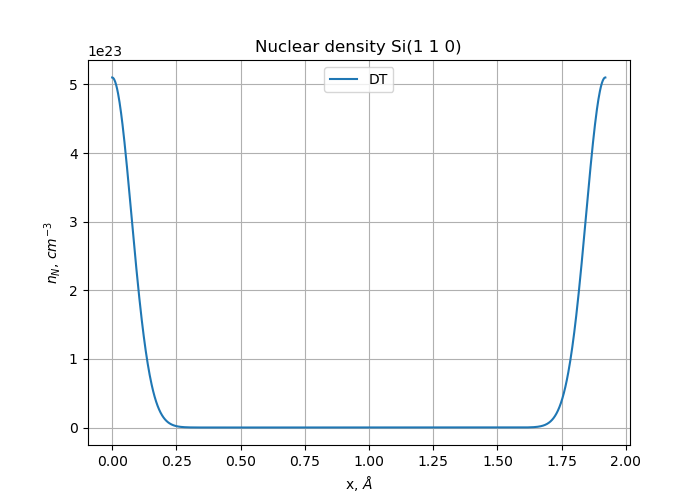

In [12]:
##Nuclear density
def n_nuc_pl(x):
    d_plm = sum(d_pl)/len(d_pl)
    dens = N*d_plm/(np.sqrt(2*np.pi*u**2))*np.exp(-(x**2/(2*u**2))) 
    return dens
print(d_pl)
N_pl = []
for n in range(0, len(posizioni_proiettate)):
    N_pl.append(n_nuc_pl(x_DT-posizioni_proiettate[n])/1e-24) # to cm-3
n_pl_tot = sum(N_pl)
print(np.shape(n_pl_tot))

figure, ax = plt.subplots(figsize=(7,5))
ax.plot(x_DT, n_pl_tot, label="DT")
ax.set_title("Nuclear density "+ Material + "("+asse+")")
ax.set_ylabel("$n_N$, $cm^{-3}$")
ax.set_xlabel("x, $\AA$")
ax.legend()
ax.grid()
plt.show()

[3.84]
7.356291542095457e+24 0.0


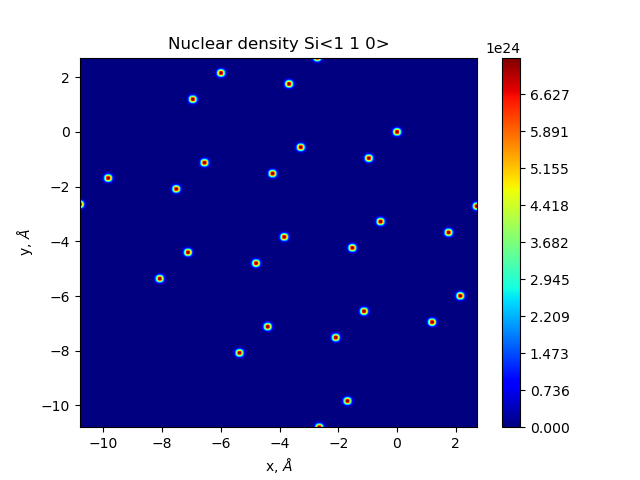

In [13]:
##Nuclear density
def n_nuc_ax(xp,yp,x_0,y_0):
    d_atm = sum(d_at)/len(d_at)
    dens = (1/(2*np.pi*d_atm*u**2))*np.exp(-((xp-x_0)**2+(yp-y_0)**2)/(2*u**2))/1e-24 # to cm-3
    # print (x_0,y_0, dens)
    return dens
print(d_at)

N_tot= np.zeros_like(xx)
for atom in atom_positions:
    N_tot += n_nuc_ax(xx,yy,atom[0],atom[1]) 
    #print(dU_dx, dU_dy)

N_max, N_min = [], []
for Na in N_tot:
    N_max.append(max(Na))
    N_min.append(min(Na))
    
N_top, N_bottom = max(N_max), min(N_min)
print(N_top, N_bottom)
# Make the graph
levels = np.linspace(N_bottom, N_top, 1000)
fig, ax=plt.subplots()
plt.contourf(xx, yy, N_tot, levels, cmap='jet') #levels,
plt.colorbar()
plt.title("Nuclear density "+ Material + "<"+asse+">")
plt.xlabel('x, $\AA$')
plt.ylabel('y, $\AA$')
#plt.zlabel('Nuclear density axial, $$')
plt.show()

## Electron density distribution 

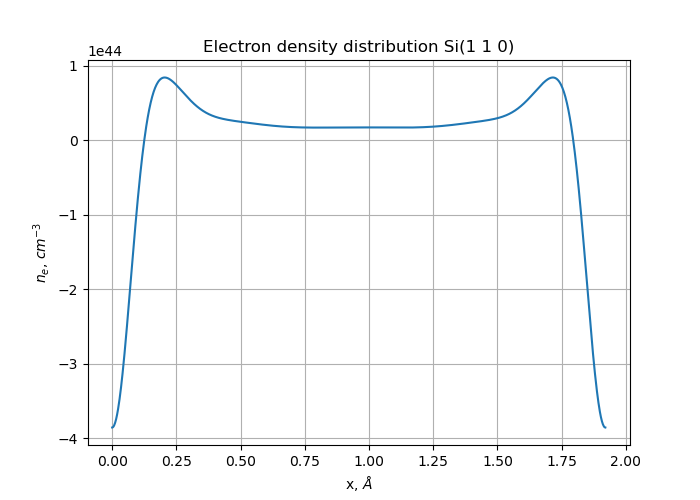

In [14]:
#definition of U_pl"
def fd2U_pl_DT_dx2(xpos):
    d_plm = sum(d_pl)/len(d_pl)
    E = 2*np.sqrt(np.pi)*N*d_plm*Z*z*e*a_0
    k1 = [E*((4*xpos**2-2*(coeff_B[i]+2*u**2))*coeff_a[i]/((coeff_B[i]+2*u**2)**(5/2)))*np.exp(-xpos**2/(coeff_B[i]+2*u**2))/10**(-24) for i in range(0,len(coeff_a))]
    k = sum(k1)
    return k

def fn_e_pl(xpos):
    return fd2U_pl_DT_dx2(xpos)/(4*np.pi*e**2)-Z*n_nuc_pl(xpos)

n_e_pl = []
for n in range(0, len(posizioni_proiettate)):
    n_e_pl.append(fn_e_pl(x_DT-posizioni_proiettate[n]))
    #n_e_pl.append(fd2U_pl_DT_dx2(x_DT-posizioni_proiettate[n]))
n_e_pl_tot = sum(n_e_pl)

figure, ax = plt.subplots(figsize=(7,5))
ax.plot(x_DT, n_e_pl_tot)
ax.set_title("Electron density distribution "+ Material + "("+asse+")")
ax.set_ylabel("$n_e$, $cm^{-3}$")
ax.set_xlabel("x, $\AA$")
#ax.legend()
ax.grid()
plt.show()

3.3214813651719645e+38 1.9779972924895788e+41


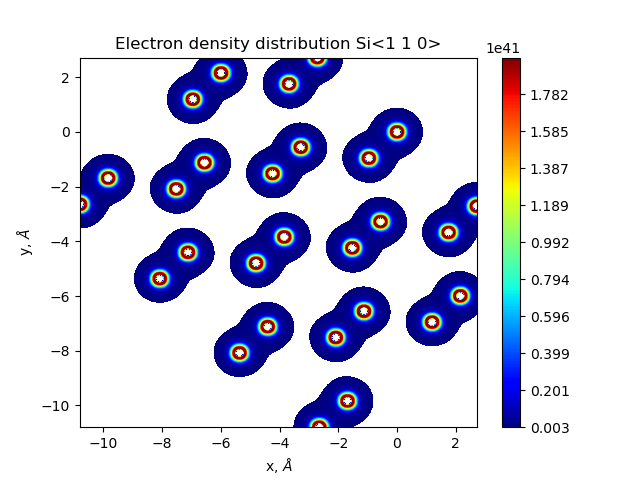

In [15]:
## axial electronic distribution:
def gradient(x,y,x_0,y_0):
    d_atm = sum(d_at)/len(d_at)
    dU_dx = -2/d_atm*Z*z*e*a_0*sum([-2*(x-x_0)*coeff_a[i]/(coeff_B[i]+2*u**2)**2 * np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(len(coeff_a))])/e
    dU_dy = -2/d_atm*Z*z*e*a_0*sum([-2*(y-y_0)*coeff_a[i]/(coeff_B[i]+2*u**2)**2 * np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(len(coeff_a))])/e
    return dU_dx, dU_dy

def fLap_U_ax(x, y, x_0, y_0):
    d_atm = sum(d_at)/len(d_at)
    d2U_dx2 = -2/d_atm*Z*z*e*a_0*sum([2*coeff_a[i]/(coeff_B[i]+2*u**2)**4*((coeff_B[i]+2*u**2)-2*(x-x_0)**2) * np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(len(coeff_a))])/e
    d2U_dy2 = -2/d_atm*Z*z*e*a_0*sum([2*coeff_a[i]/(coeff_B[i]+2*u**2)**4*((coeff_B[i]+2*u**2)-2*(y-y_0)**2) * np.exp(-((x-x_0)**2+(y-y_0)**2)/(coeff_B[i]+2*u**2)) for i in range(len(coeff_a))])/e
    return d2U_dx2 + d2U_dy2

def fn_e_ax(x, y, x_0, y_0):
    return fLap_U_ax(x, y, x_0, y_0)/(4*np.pi*scipy.constants.e**2)-Z*n_nuc_ax(x,y,x_0,y_0)

n_e_ax = np.zeros_like(xx)
for atom in atom_positions:
    n_e_ax += fn_e_ax(xx,yy,atom[0],atom[1]) 

n_e_ax_max, n_e_ax_min = [], []
for neax in n_e_ax:
    n_e_ax_max.append(max(neax))
    n_e_ax_min.append(min(neax))
    
n_e_ax_top, n_e_ax_bottom = max(n_e_ax_max), min(n_e_ax_max)
#print(np.amin(n_e_ax),  np.amax(n_e_ax))
print(n_e_ax_bottom,  n_e_ax_top)
# Make the graph
levels = np.linspace(n_e_ax_bottom,  n_e_ax_top, 1000)
fig, ax=plt.subplots()
plt.contourf(xx, yy, n_e_ax, levels, cmap='jet') #levels,
plt.colorbar()
plt.title("Electron density distribution "+ Material + "<"+ asse +">") 
plt.xlabel('x, $\AA$')
plt.ylabel('y, $\AA$')
plt.show()